# 1. Importando bibliotecas e o Dataset

## 1.1 Importando bibliotecas necessárias

In [21]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2
from google.colab import drive
import zipfile
import os
from torchvision import transforms
from torchvision.transforms import RandomAffine
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
#Full path of the source ZIP File and destination directory
caminho_zip = '/content/drive/MyDrive/PickCells/fracture_detection/bone_fracture_data_CV-20240131T171345Z-001.zip'
diretorio_destino = '/content'

#Extract the ZIP File
with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
    zip_ref.extractall(diretorio_destino)

print("ZIP file extracted successfully.")

ZIP file extracted successfully.


In [24]:
os.listdir('/content/bone_fracture_data_CV/train/')

['Impacted fracture',
 'Hairline Fracture',
 'Comminuted fracture',
 'Fracture Dislocation',
 'Oblique fracture',
 'Longitudinal fracture',
 'Pathological fracture',
 'Greenstick fracture',
 'Spiral Fracture',
 'Avulsion fracture']

In [25]:
train_dataset_path = '/content/bone_fracture_data_CV/train/'
test_dataset_path = '/content/bone_fracture_data_CV/test/'

#2. Pré-Processamento de Dados

## 2.1 Depois de vários testes, essas transformações foram as que mais trouxeram resultados para o treinamento. OBS: Normalização e ajustes de brilho e contraste não trouxeram bons resultados

In [26]:
train_transforms = transforms.Compose([
    transforms.Resize((150, 100)),
    transforms.RandomVerticalFlip(),    # Adiciona flip vertical aleatório
    transforms.RandomHorizontalFlip(),  # Adiciona flip horizontal aleatório
    transforms.RandomRotation(degrees=45),  # Adiciona rotação aleatória no intervalo de -45 a 45 graus
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((150, 100)),
    transforms.ToTensor()
])

## Como as imagens de cada classe não estavam desbalanceadas, não foi preciso regularizá-las.

In [27]:
batch_size = 32# Tamanho do lote (processa 32 imagens por vez)

train_dataset = torchvision.datasets.ImageFolder(root=train_dataset_path, transform=train_transforms)# Diretório raiz das imagens de treinamento
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #Transformações aplicadas às imagens de treinamento

test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform=test_transforms) #Diretório raiz das imagens de teste
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #Transformações aplicadas às imagens de teste


classes = ('Impacted fracture', # Nomes das 10 classes de fraturas
 'Pathological fracture',
 'Spiral Fracture',
 'Oblique fracture',
 'Avulsion fracture',
 'Comminuted fracture',
 'Greenstick fracture',
 'Longitudinal fracture',
 'Hairline Fracture',
 'Fracture Dislocation')

## 2.2 Visualização do tratamento realizado nas imagens



In [28]:
def show_transformed_images(dataset):
  """
  Função para visualizar um conjunto de imagens após serem transformadas.

  Argumentos:
    dataset: Conjunto de dados PyTorch com as imagens transformadas.

  Retorno:
    Exibe uma grade com as imagens e imprime os rótulos correspondentes.
  """

  # Cria um carregador de dados para o conjunto de dados
  loader = torch.utils.data.DataLoader(dataset, batch_size=21, shuffle=False)

  # Obtém o próximo lote de imagens e rótulos
  batch = next(iter(loader))
  images, labels = batch  # Desempacota as imagens e rótulos do lote

  # Cria uma grade com as imagens
  grid = torchvision.utils.make_grid(images, nrow=3)  # Reorganiza as imagens em uma grade 3x7

  # Mostra a grade de imagens
  plt.figure(figsize=(30, 30))  # Cria uma figura com tamanho 30x30
  plt.imshow(np.transpose(grid, (1, 2, 0)))  # Exibe a grade de imagens (transposição necessária para o formato do Matplotlib)
  print('labels: ', labels)  # Imprime os rótulos correspondentes às imagens

labels:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


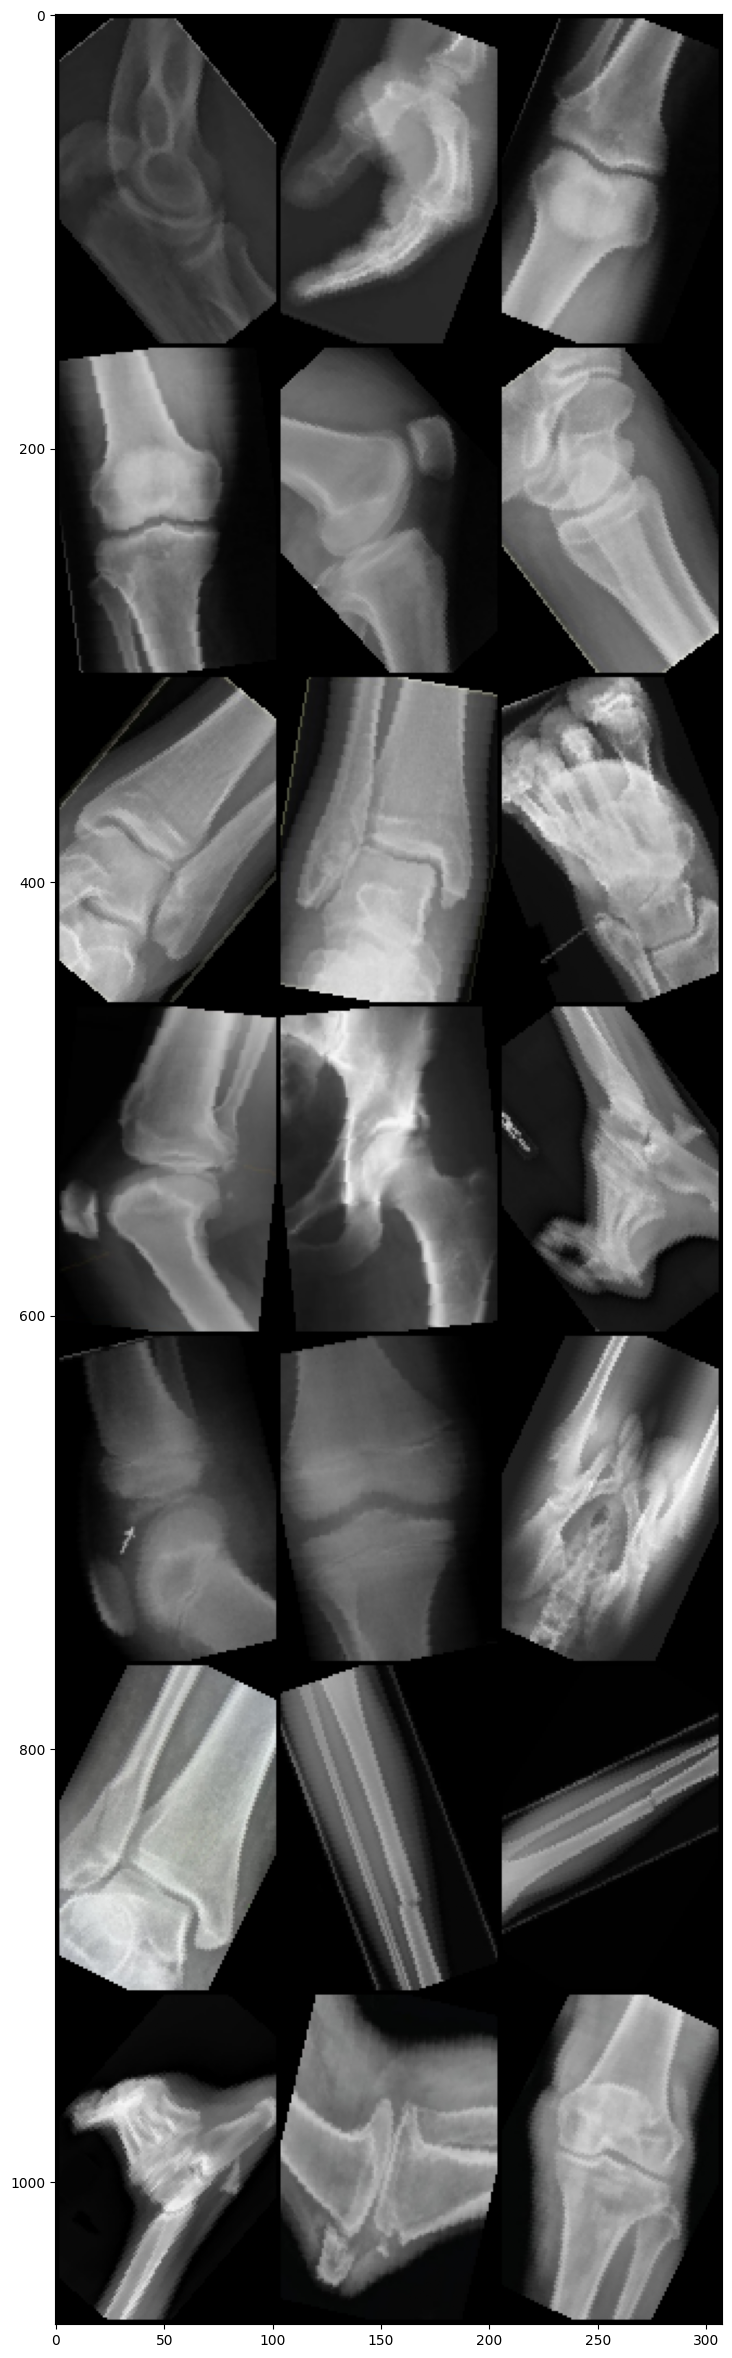

In [29]:
show_transformed_images(train_dataset)

## 2.3 Funções de Treinamento

In [30]:
def set_device():
  # Verifica se uma GPU habilitada para CUDA está disponível
  if torch.cuda.is_available():
    # Se uma GPU estiver disponível, define o dispositivo como o primeiro dispositivo CUDA (índice 0)
    dev = "cuda:0"
  else:
    # Se uma GPU não estiver disponível, define o dispositivo como CPU
    dev = "cpu"
  # Retorna o objeto torch.device representando o dispositivo selecionado
  return torch.device(dev)


In [31]:
def plot_accuracy_curve(train_accuracy, test_accuracy, title='Curva de Acurácia ao Longo dos Epochs'):
    """
    Plota a curva de acurácia ao longo dos epochs.

    Parameters:
    - train_accuracy: Lista ou array da acurácia de treinamento ao longo dos epochs.
    - test_accuracy: Lista ou array da acurácia de teste ao longo dos epochs.
    - title: Título do gráfico (opcional).

    Returns:
    - None (exibe o gráfico).
    """
    epochs = np.arange(1, len(train_accuracy) + 1)

    plt.plot(epochs, train_accuracy, label='Acurácia de Treinamento', marker='o')
    plt.plot(epochs, test_accuracy, label='Acurácia de Teste', marker='o')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    # Define o dispositivo onde os cálculos serão executados
    device = set_device()
    # Dicionário para armazenar valores de acurácia para plotagem
    history = {'train_acc': [], 'test_acc': []}  # Store accuracy values for plotting
    # Loop sobre o número especificado de épocas
    for epoch in range(n_epochs):
        print("Epoch number %d " % (epoch + 1))
        model.train() # Define o modelo para modo de treinamento
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader: # Loop sobre os dados de treinamento
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()  # Zera os gradientes acumulados no otimizador
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() # Inicializa variáveis ​​para calcular a perda e a precisão
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print("    - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch Loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))

        # Store training accuracy in the history dictionary
        history['train_acc'].append(epoch_acc)

        test_accuracy = evaluate_model_on_test_set(model, test_loader)

        # Store test accuracy in the history dictionary
        history['test_acc'].append(test_accuracy)

    print("Finished")
    return model, history

In [33]:
def evaluate_model_on_test_set(model, test_loader):
  model.eval()
  predicted_correctly_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)

      predicted_correctly_on_epoch += (predicted == labels).sum().item()

  epoch_acc = 100.0 * predicted_correctly_on_epoch / total
  print("    - Testing dataset. Got %d out of %d images correctly (%.3f%%) "
          % (predicted_correctly_on_epoch, total, epoch_acc))
  return epoch_acc

In [34]:
def evaluate_model(model, data_loader, class_names):
    model.eval()
    device = set_device()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions)
    classification_rep = classification_report(all_labels, all_predictions, target_names=class_names)

    return confusion, classification_rep

# Uso:
class_names = ['Impacted fracture', 'Pathological fracture', 'Spiral Fracture', 'Oblique fracture', 'Avulsion fracture',
               'Comminuted fracture', 'Greenstick fracture', 'Longitudinal fracture', 'Hairline Fracture', 'Fracture Dislocation']


In [35]:
def get_avg(model, data_loader, class_names):
    model.eval()
    device = set_device()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions)
    classification_rep = classification_report(all_labels, all_predictions, target_names=class_names, output_dict=True)
    return confusion, classification_rep

# Uso:
class_names = ['Impacted fracture', 'Pathological fracture', 'Spiral Fracture', 'Oblique fracture', 'Avulsion fracture',
               'Comminuted fracture', 'Greenstick fracture', 'Longitudinal fracture', 'Hairline Fracture', 'Fracture Dislocation']


# 3. Testando modelo RESNET50



## 3.1 Importação do Modelo e definindo hiperparâmetros

In [36]:
#Importando modelo e definição de hiperparâmetros
resnet50_model = models.resnet50(pretrained=True)
num_ftrs = resnet50_model.fc.in_features
number_of_classes = 10
resnet50_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet50_model = resnet50_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet50_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001) #Hyperparameters, attention to 'lr'!!!! 0.01~0.001, weight_decay to prevent overfitting since the dataset is small

3.2 Treinando o modelo

In [37]:
model, history = train_nn(resnet50_model, train_loader, test_loader, loss_fn, optimizer, 200)

Epoch number 1 
    - Training dataset. Got 104 out of 989 images correctly (10.516%). Epoch Loss: 2.337
    - Testing dataset. Got 20 out of 140 images correctly (14.286%) 
Epoch number 2 
    - Training dataset. Got 138 out of 989 images correctly (13.953%). Epoch Loss: 2.287
    - Testing dataset. Got 25 out of 140 images correctly (17.857%) 
Epoch number 3 
    - Training dataset. Got 144 out of 989 images correctly (14.560%). Epoch Loss: 2.263
    - Testing dataset. Got 24 out of 140 images correctly (17.143%) 
Epoch number 4 
    - Training dataset. Got 176 out of 989 images correctly (17.796%). Epoch Loss: 2.247
    - Testing dataset. Got 23 out of 140 images correctly (16.429%) 
Epoch number 5 
    - Training dataset. Got 175 out of 989 images correctly (17.695%). Epoch Loss: 2.231
    - Testing dataset. Got 25 out of 140 images correctly (17.857%) 
Epoch number 6 
    - Training dataset. Got 211 out of 989 images correctly (21.335%). Epoch Loss: 2.214
    - Testing dataset. Go

## 3.3 Avaliando modelo

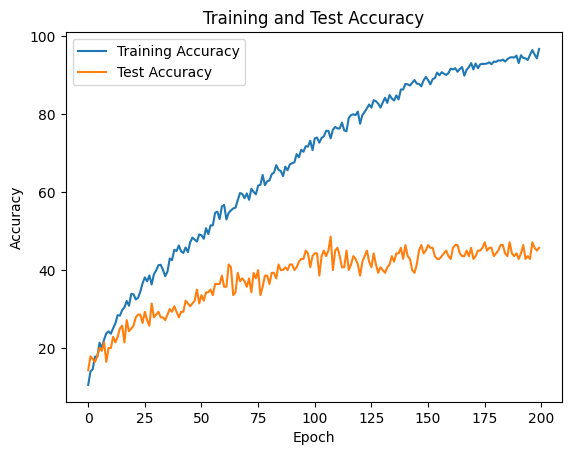

In [38]:
#Gera gráfico de acurácia de treino e de teste
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

In [39]:
#Gera matriz de confusão
confusion_matrix1, classification_report1 = evaluate_model(resnet50_model, test_loader, class_names)

print("Confusion Matrix:")
print(confusion_matrix1)

print("\nClassification Report:")
print(classification_report1)

Confusion Matrix:
[[12  1  0  0  0  0  1  0  0  0]
 [ 0  7  2  0  1  0  0  2  2  0]
 [ 1  2  9  2  1  1  0  1  2  0]
 [ 1  0  2 11  0  1  0  0  0  1]
 [ 3  0  1  0  3  0  1  1  1  0]
 [ 0  2  1  0  1  3  1  0  0  1]
 [ 3  0  0  2  1  0  4  0  1  1]
 [ 2  1  2  2  2  1  1  3  1  1]
 [ 1  2  2  1  1  1  2  0  7  1]
 [ 0  0  0  1  0  0  5  0  1  5]]

Classification Report:
                       precision    recall  f1-score   support

    Impacted fracture       0.52      0.86      0.65        14
Pathological fracture       0.47      0.50      0.48        14
      Spiral Fracture       0.47      0.47      0.47        19
     Oblique fracture       0.58      0.69      0.63        16
    Avulsion fracture       0.30      0.30      0.30        10
  Comminuted fracture       0.43      0.33      0.38         9
  Greenstick fracture       0.27      0.33      0.30        12
Longitudinal fracture       0.43      0.19      0.26        16
    Hairline Fracture       0.47      0.39      0.42       

In [40]:
#Acessa a acurácia média do modelo
confusion_matrix1, classification_report1 = get_avg(resnet50_model, test_loader, class_names)
#Armazena a acurácia média do modelo
resnet_macro_avg_precision = classification_report1['macro avg']['precision']

In [41]:
#Salva o Modelo
torch.save(resnet50_model.state_dict(), 'resnet50_best_model.pth')

#4. Testando modelo DENSENET

## 4.1 Importando modelo e definindo hiperparâmetros

In [42]:
#Importa o modelo
densenet169_model = models.densenet169(pretrained=True)
num_ftrs = densenet169_model.classifier.in_features
number_of_classes = 10
densenet169_model.classifier = nn.Linear(num_ftrs, number_of_classes)

# Defina o dispositivo
device = set_device()
densenet169_model = densenet169_model.to(device)

# Defina hiperparâmetros
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet169_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 93.9MB/s]


## 4.2 Treinando o modelo

In [43]:
# Treine o modelo
model, history = train_nn(densenet169_model, train_loader, test_loader, loss_fn, optimizer, 150)

Epoch number 1 
    - Training dataset. Got 100 out of 989 images correctly (10.111%). Epoch Loss: 2.377
    - Testing dataset. Got 16 out of 140 images correctly (11.429%) 
Epoch number 2 
    - Training dataset. Got 144 out of 989 images correctly (14.560%). Epoch Loss: 2.289
    - Testing dataset. Got 20 out of 140 images correctly (14.286%) 
Epoch number 3 
    - Training dataset. Got 172 out of 989 images correctly (17.391%). Epoch Loss: 2.273
    - Testing dataset. Got 20 out of 140 images correctly (14.286%) 
Epoch number 4 
    - Training dataset. Got 161 out of 989 images correctly (16.279%). Epoch Loss: 2.241
    - Testing dataset. Got 21 out of 140 images correctly (15.000%) 
Epoch number 5 
    - Training dataset. Got 212 out of 989 images correctly (21.436%). Epoch Loss: 2.179
    - Testing dataset. Got 27 out of 140 images correctly (19.286%) 
Epoch number 6 
    - Training dataset. Got 236 out of 989 images correctly (23.862%). Epoch Loss: 2.150
    - Testing dataset. Go

## 4.3 Avaliando o modelo

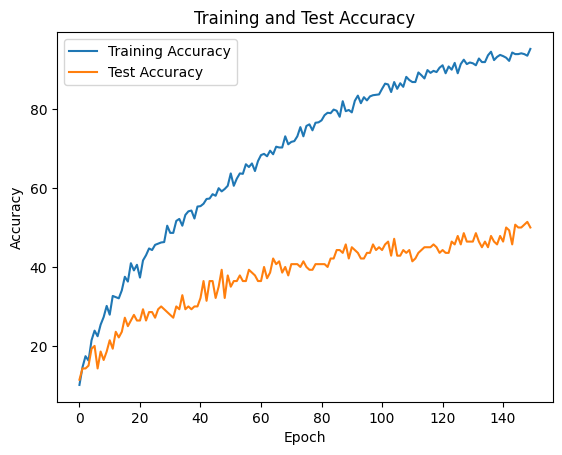

In [44]:
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

In [45]:
confusion_matrix2, classification_report2 = evaluate_model(densenet169_model, test_loader, class_names)

print("Confusion Matrix:")
print(confusion_matrix2)

print("\nClassification Report:")
print(classification_report2)

Confusion Matrix:
[[ 7  0  0  0  4  1  1  1  0  0]
 [ 0  6  1  3  1  0  0  2  1  0]
 [ 0  0 11  2  2  1  0  0  2  1]
 [ 0  1  2 11  0  2  0  0  0  0]
 [ 2  0  0  0  6  2  0  0  0  0]
 [ 0  1  1  0  0  6  0  1  0  0]
 [ 1  0  0  3  1  0  4  1  2  0]
 [ 0  1  1  1  6  2  1  4  0  0]
 [ 1  0  3  2  0  1  2  0  8  1]
 [ 0  0  1  1  0  2  1  0  0  7]]

Classification Report:
                       precision    recall  f1-score   support

    Impacted fracture       0.64      0.50      0.56        14
Pathological fracture       0.67      0.43      0.52        14
      Spiral Fracture       0.55      0.58      0.56        19
     Oblique fracture       0.48      0.69      0.56        16
    Avulsion fracture       0.30      0.60      0.40        10
  Comminuted fracture       0.35      0.67      0.46         9
  Greenstick fracture       0.44      0.33      0.38        12
Longitudinal fracture       0.44      0.25      0.32        16
    Hairline Fracture       0.62      0.44      0.52       

In [46]:
#Acessa a acurácia média do modelo
confusion_matrix2, classification_report2 = get_avg(densenet169_model, test_loader, class_names)
#Armazena a acurácia média do modelo
densenet_macro_avg_precision = classification_report2['macro avg']['precision']

In [47]:
#Salva o modelo
torch.save(densenet169_model.state_dict(), 'densenet_best_model.pth')

#5. Testando Modelo Customizado

## 5.1 Criando o modelo

In [73]:
class BoneFractureInceptionNet(nn.Module):
    def __init__(self):
        super(BoneFractureInceptionNet, self).__init__()

        # Módulo Inception
        def inception_module(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels // 4, kernel_size=1, stride=1, padding=0),
                nn.Conv2d(in_channels, out_channels // 4, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(in_channels, out_channels // 2, kernel_size=5, stride=1, padding=2),
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            )

        # Camadas da rede
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.activation1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.inception1 = inception_module(32, 64)
        self.inception2 = inception_module(64, 128)
        self.inception3 = inception_module(128, 256)

        self.fc1 = nn.Linear(230400, 256)
        self.activation4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.activation5 = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.pool1(x)

        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.activation4(x)
        x = self.fc2(x)
        x = self.activation5(x)
        x = self.fc3(x)

        return x

In [74]:
# Função para treinar o modelo
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    history = {'train_acc': [], 'test_acc': []}  # Store accuracy values for plotting

    for epoch in range(n_epochs):
        print("Epoch number %d " % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print("    - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch Loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))

        # Store training accuracy in the history dictionary
        history['train_acc'].append(epoch_acc)

        test_accuracy = evaluate_model_on_test_set(model, test_loader)

        # Store test accuracy in the history dictionary
        history['test_acc'].append(test_accuracy)
    print("Finished")
    return model, history

## 5.2 Treinamento do modelo

In [77]:
# Defina seus hiperparâmetros
learning_rate = 0.001

# Instancie seu modelo
bone_fracture_model = BoneFractureCNN()

# Defina a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bone_fracture_model.parameters(), lr=learning_rate)

In [78]:
# Treine o modelo usando a função train_nn
model, history = train_nn(bone_fracture_model, train_loader, test_loader, criterion, optimizer, 150)

Epoch number 1 
    - Training dataset. Got 130 out of 989 images correctly (13.145%). Epoch Loss: 2.288
    - Testing dataset. Got 19 out of 140 images correctly (13.571%) 
Epoch number 2 
    - Training dataset. Got 143 out of 989 images correctly (14.459%). Epoch Loss: 2.267
    - Testing dataset. Got 19 out of 140 images correctly (13.571%) 
Epoch number 3 
    - Training dataset. Got 135 out of 989 images correctly (13.650%). Epoch Loss: 2.250
    - Testing dataset. Got 19 out of 140 images correctly (13.571%) 
Epoch number 4 
    - Training dataset. Got 154 out of 989 images correctly (15.571%). Epoch Loss: 2.238
    - Testing dataset. Got 23 out of 140 images correctly (16.429%) 
Epoch number 5 
    - Training dataset. Got 154 out of 989 images correctly (15.571%). Epoch Loss: 2.240
    - Testing dataset. Got 21 out of 140 images correctly (15.000%) 
Epoch number 6 
    - Training dataset. Got 147 out of 989 images correctly (14.863%). Epoch Loss: 2.235
    - Testing dataset. Go

## 5.3 Avaliação do modelo

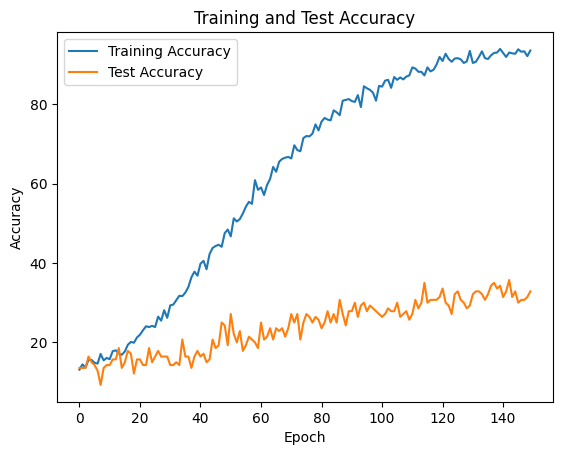

In [79]:
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

In [80]:
confusion_matrix3, classification_report3 = evaluate_model(bone_fracture_model, test_loader, class_names)

print("Confusion Matrix:")
print(confusion_matrix3)

print("\nClassification Report:")
print(classification_report3)

Confusion Matrix:
[[6 0 1 1 1 2 1 0 2 0]
 [1 5 1 1 1 2 1 1 1 0]
 [1 0 9 0 4 2 0 0 3 0]
 [0 2 2 6 0 0 1 1 4 0]
 [2 0 0 3 1 1 0 0 2 1]
 [1 2 1 1 0 2 0 0 1 1]
 [2 1 1 0 0 0 6 0 2 0]
 [1 2 2 1 2 1 2 4 1 0]
 [2 2 2 1 2 0 0 0 6 3]
 [0 0 0 2 0 0 3 1 5 1]]

Classification Report:
                       precision    recall  f1-score   support

    Impacted fracture       0.38      0.43      0.40        14
Pathological fracture       0.36      0.36      0.36        14
      Spiral Fracture       0.47      0.47      0.47        19
     Oblique fracture       0.38      0.38      0.38        16
    Avulsion fracture       0.09      0.10      0.10        10
  Comminuted fracture       0.20      0.22      0.21         9
  Greenstick fracture       0.43      0.50      0.46        12
Longitudinal fracture       0.57      0.25      0.35        16
    Hairline Fracture       0.22      0.33      0.27        18
 Fracture Dislocation       0.17      0.08      0.11        12

             accuracy           

In [81]:
#Acessando acurácia media do modelo
confusion_matrix3, classification_report3 = get_avg(bone_fracture_model, test_loader, class_names)
#Armazenando acurácia média do modelo
cnn_macro_avg_precision = classification_report3['macro avg']['precision']

In [82]:
#Salvando o modelo
torch.save(bone_fracture_model.state_dict(), 'inception_best_model.pth')

# 6. Conclusões

## 6.1 Comparando os modelos

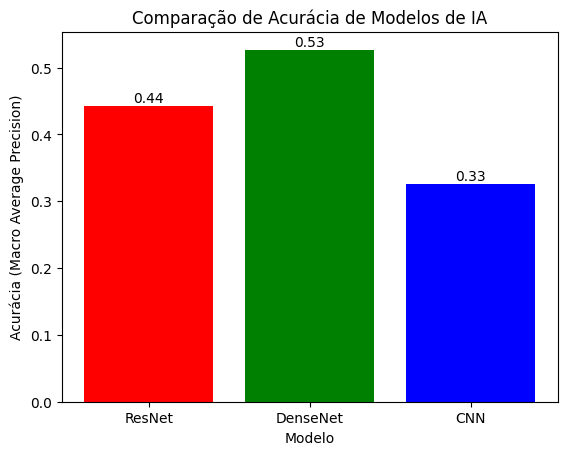

In [83]:
modelos = ["ResNet", "DenseNet", "CNN"]
acuracias = [resnet_macro_avg_precision, densenet_macro_avg_precision, cnn_macro_avg_precision]
plt.bar(modelos, acuracias, color=["r", "g", "b"])
plt.xlabel("Modelo")
plt.ylabel("Acurácia (Macro Average Precision)")
plt.title("Comparação de Acurácia de Modelos de IA")

# Adicionar valores de acurácia em cima das barras
for i in range(len(modelos)):
    plt.text(i, acuracias[i], f"{acuracias[i]:.2f}", ha="center", va="bottom")

plt.show()

## 7. Conclusão

**Problemática:** Por se tratar de um dataset muito complexo, modelos de aprendizado de máquina com muitos neurônios não é a solução do problema, pois o treinamento acaba decorando as imagens de treinamento e não generaliza para as imagens de treino.

**Ação:** Como solução para o problema foquei em fazer vários testes para ter certeza da melhor configuração de pré-processamento e equilibrei os Numero de batchs, a velocidade de aprendizado do modelo e compensação de pesos de forma que pudesse evitar o overfitting. Ao testar o método de DropOut não tive bons resultados.

**Sugestão:** Para melhorar a eficácia do modelo suponho que o acompanhamento de algum profissional de área médica realizando uma classificação através de anotações seria uma boa solução.